# Reccomendations to AGM:

1. Put a greater focus on growing the Nashville customer base, and consequently sales.

2. Conduct further analysis on AGM's top customers in the different stores.

3. Look into removing the chicken salad and spinach orzo from the product selection.

In [10]:
# Import necessary packages
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    '''This function will run a selected query in Postgres and 
    return the rows in a pandas dataframe'''
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # Below converts float columns that integer columns, for those that should be integer columns.
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

##### We will begin by understanding AGM's sales in the past year.

In [3]:
# Calculate total sales (number and amount), by store

rollback_before_flag = True
rollback_after_flag = True

query = """

select stores.city, count(sale_id) as number_sales, sum(sales.total_amount) as total_sales
from stores
    join sales
        on stores.store_id = sales.store_id
group by stores.city
order by number_sales desc
"""

print('Table 1: Breakdown of Sales by Store')
df_store = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_store

Table 1: Breakdown of Sales by Store


,city,number_sales,total_sales
0,Berkeley,390375,25041060
1,Seattle,342327,22024512
2,Dallas,302120,19408260
3,Miami,275074,17692404
4,Nashville,227721,14573172


In [4]:
# Get proportional breakdown 

no_sales = sum(df_store['number_sales'])

usd_sales = sum(df_store['total_sales'])

print()

df_store['number_sales_prop'] = (df_store['number_sales']/no_sales)*100
df_store['total_sales_prop'] = (df_store['total_sales']/usd_sales)*100

print('Table 2: Breakdown of Sales by Store (Proportions)')
df_store[['city', 'number_sales_prop','total_sales_prop']]


Table 2: Breakdown of Sales by Store (Proportions)


,city,number_sales_prop,total_sales_prop
0,Berkeley,25.388312,25.360756
1,Seattle,22.263477,22.305696
2,Dallas,19.648586,19.656042
3,Miami,17.889631,17.91828
4,Nashville,14.809995,14.759226


In terms of overall sales, the Berkeley store performed the best in terms of number of sales and total sale amounts (table 1). It was followeed by Seattle, Dallas, Miami, and finally by Nashville. According to table 2 it seems that the Berkeley store accounted for about a quarter of AGM's sales. 

Based on these two tables, one can infer that there is still some work to be done to help especially the Nashville store grow.

##### Next we will look at the meals that have been purchased.

In [5]:
# Calculate proportions of the different meal choices

rollback_before_flag = True
rollback_after_flag = True

query = """

select products.description, sum(line_items.quantity) as total_meals_purchased, count(*) * 100/ sum(count(*)) over () as meal_proportion
from line_items
     join products
          on line_items.product_id = products.product_id
group by products.description
order by meal_proportion desc
"""

print('Table 3: Breakdown of Different Meal Products Sold')
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)


Table 3: Breakdown of Different Meal Products Sold


,description,total_meals_purchased,meal_proportion
0,Pistachio Salmon,1828778,18.807492
1,Eggplant Lasagna,1599058,17.530077
2,Curry Chicken,1368884,16.029202
3,Teriyaki Chicken,1145013,14.332535
4,Brocolli Stir Fry,913984,12.302901
5,Tilapia Piccata,687237,9.963724
6,Spinach Orzo,456769,7.152194
7,Chicken Salad,228561,3.881875


Graphs 1, 2, 3, 4, 5


<ipython-input-6-290d3beed718>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(df_mealsB['meals'],rotation=15, ha='right')
<ipython-input-6-290d3beed718>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(df_mealsD['meals'],rotation=15, ha='right')
<ipython-input-6-290d3beed718>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(df_mealsM['meals'],rotation=15, ha='right')
<ipython-input-6-290d3beed718>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(df_mealsN['meals'],rotation=15, ha='right')
<ipython-input-6-290d3beed718>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2,0].set_xticklabels(df_mealsS['meals'],rotation=15, ha='right')


Text(0.5, 1.0, 'NA')

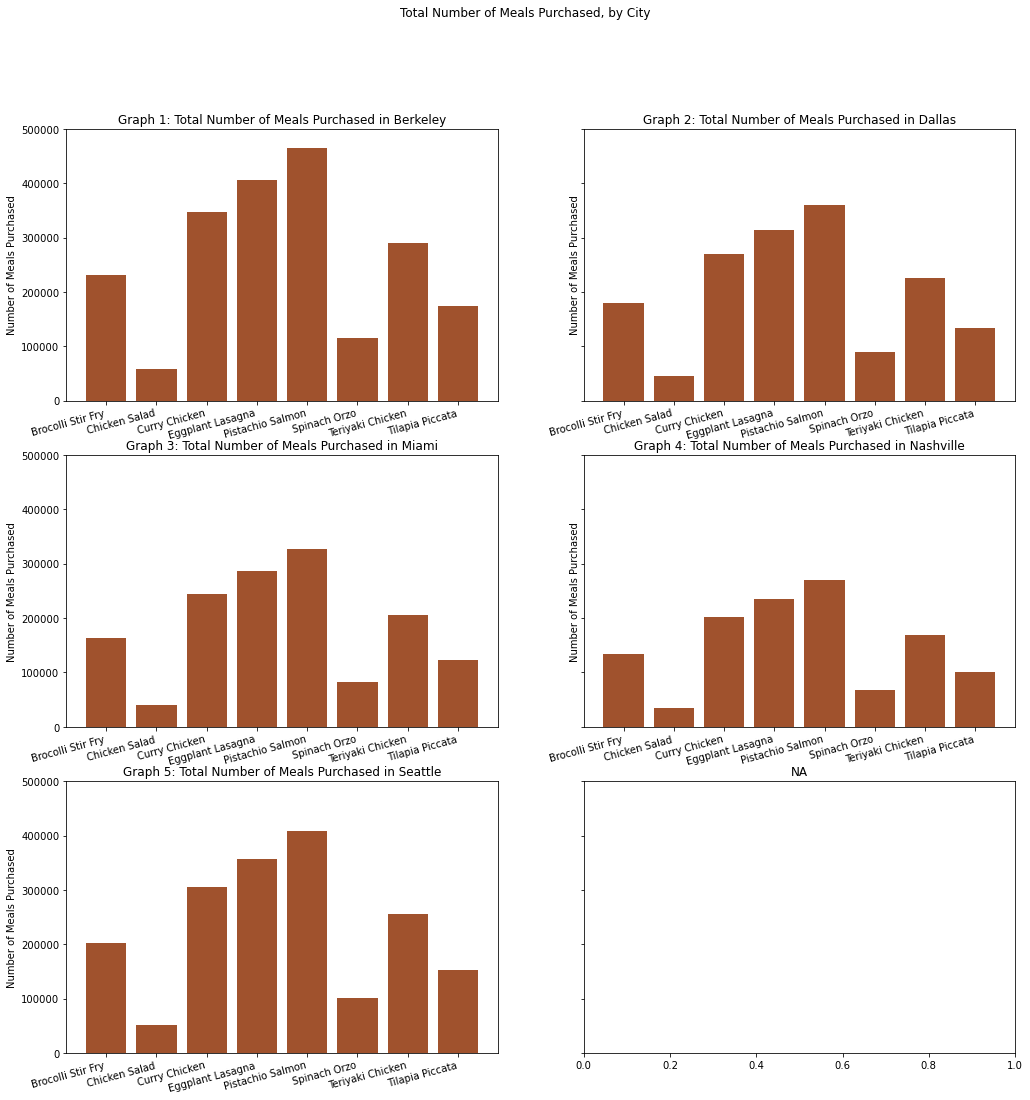

In [6]:
# Look at Meals by Store 

# Get SQL Query
rollback_before_flag = True
rollback_after_flag = True

query = """

select stores.city, products.description as meals, sum(line_items.quantity) as total_meals_purchased
from line_items
     join products
          on line_items.product_id = products.product_id
     join stores
          on line_items.store_id = stores.store_id       
group by stores.city, products.description
order by products.description asc
"""

df_meals = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Create Graphs for each city on breakdowns of meals sold by month
df_mealsB = df_meals[df_meals['city']=='Berkeley']
df_mealsD = df_meals[df_meals['city']=='Dallas']
df_mealsM = df_meals[df_meals['city']=='Miami']
df_mealsN = df_meals[df_meals['city']=='Nashville']
df_mealsS = df_meals[df_meals['city']=='Seattle']

print('Graphs 1, 2, 3, 4, 5')

fig, axes = plt.subplots(3,2, figsize = (17,17), sharey='row')
fig.suptitle('Total Number of Meals Purchased, by City')
axes[0,0].set_title('Graph 1: Total Number of Meals Purchased in Berkeley')
axes[0,0].bar(df_mealsB['meals'], df_mealsB['total_meals_purchased'], color='sienna')
#axes[0,0].set_xlabel('Meals')
axes[0,0].set_ylabel('Number of Meals Purchased')
axes[0,0].set_ylim(0, 500000)
axes[0,0].set_xticklabels(df_mealsB['meals'],rotation=15, ha='right')

axes[0,1].set_title('Graph 2: Total Number of Meals Purchased in Dallas')
axes[0,1].bar(df_mealsD['meals'], df_mealsD['total_meals_purchased'], color='sienna')
# axes[0,1].set_xlabel('Meals')
axes[0,1].set_ylabel('Number of Meals Purchased')
axes[0,1].set_ylim(0, 500000)
axes[0,1].set_xticklabels(df_mealsD['meals'],rotation=15, ha='right')


axes[1,0].set_title('Graph 3: Total Number of Meals Purchased in Miami')
axes[1,0].bar(df_mealsM['meals'], df_mealsM['total_meals_purchased'], color='sienna')
# axes[1,0].set_xlabel('Meals')
axes[1,0].set_ylabel('Number of Meals Purchased')
axes[1,0].set_ylim(0, 500000)
axes[1,0].set_xticklabels(df_mealsM['meals'],rotation=15, ha='right')


axes[1,1].set_title('Graph 4: Total Number of Meals Purchased in Nashville')
axes[1,1].bar(df_mealsN['meals'], df_mealsN['total_meals_purchased'], color='sienna')
# axes[1,1].set_xlabel('Meals')
axes[1,1].set_ylabel('Number of Meals Purchased')
axes[1,1].set_ylim(0, 500000)
axes[1,1].set_xticklabels(df_mealsN['meals'],rotation=15, ha='right')


axes[2,0].set_title('Graph 5: Total Number of Meals Purchased in Seattle')
axes[2,0].bar(df_mealsS['meals'], df_mealsS['total_meals_purchased'], color='sienna')
# axes[2,0].set_xlabel('Meals')
axes[2,0].set_ylabel('Number of Meals Purchased')
axes[2,0].set_ylim(0, 500000)
axes[2,0].set_xticklabels(df_mealsS['meals'],rotation=15, ha='right')

axes[2,1].set_title('NA')


Table 3 above shows the breakdown of how the different meals had been sold in 2020. The top three performing meals were the pistachio salmon, eggplant lasagna, and curry chicken - together making up about half of AGM's sales. The bottom two performing meals were the chicken salad (about 4%) and then the spinach orzo ( about 7%). This ranking also seems to hold true across the different stores according to grahs 1-5 - implying that there are no strong market-specific meal preferences.

Given that these two meals make up a relatively small proportion of meals being sold, if AGM were looking to simplify their food production processes, they could remove these two meals. Or if they wanted to try bringing in new meals, they could replace these two, given their lower rates of success.

##### And finally, we will investigate AGM's current customer based. 

In [12]:
# Calculate total Number of Customers by Store

rollback_before_flag = True
rollback_after_flag = True

query = """

select stores.city, count(distinct sales.customer_id) as total_customers, count(*) * 100/ sum(count(*)) over () as city_customers_proportion
from customers
join sales
     on sales.customer_id = customers.customer_id
join stores
     on stores.store_id = sales.store_id
group by stores.city 
order by city_customers_proportion desc

"""

print('Table 4: Breakdown of Total Number of Customers by Store')
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

Table 4: Breakdown of Total Number of Customers by Store


,city,total_customers,city_customers_proportion
0,Berkeley,8126,25.388312
1,Seattle,7206,22.263477
2,Dallas,6355,19.648586
3,Miami,5720,17.889631
4,Nashville,3640,14.809995


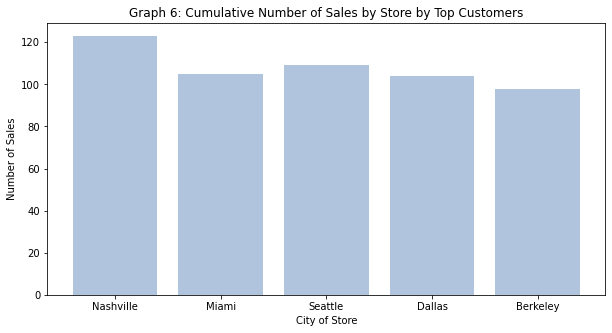

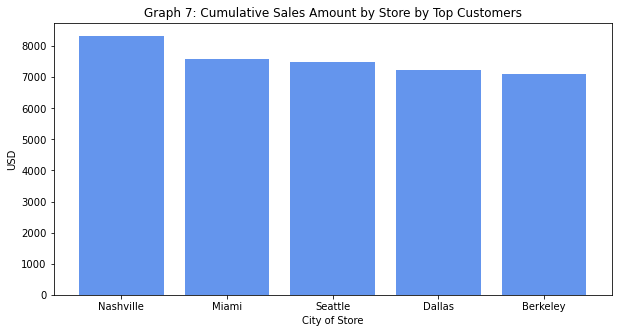

In [13]:
# Query the top customers
rollback_before_flag = True
rollback_after_flag = True

query = """
select sales.customer_id, stores.city, count(distinct sales.sale_id) as distinct_sales, sum(sales.total_amount) as total_amount_sales
from sales
join stores
     on stores.store_id = sales.store_id 
group by customer_id, stores.city
having sum(sales.total_amount) >= 6123
order by total_amount_sales desc
"""

df_cs_top = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_cs_top

plt.figure(figsize=(10,5))
plt.bar(df_cs_top['city'], df_cs_top['distinct_sales'], color='lightsteelblue')
plt.title('Graph 6: Cumulative Number of Sales by Store by Top Customers')
plt.xlabel('City of Store')
plt.ylabel('Number of Sales')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(df_cs_top['city'], df_cs_top['total_amount_sales'], color='cornflowerblue')
plt.title('Graph 7: Cumulative Sales Amount by Store by Top Customers')
plt.xlabel('City of Store')
plt.ylabel('USD')
plt.show()

In [9]:
df_topc = df_cs_top[['city', 'customer_id']]

print('Table 5: Breakdown of Top Customers by Store')
df_topc.groupby('city').count()

Table 5: Breakdown of Top Customers by Store


,customer_id
city,
Berkeley,18
Dallas,80
Miami,86
Nashville,526
Seattle,95


Just as table 2 showed the Berkeley store being accountable for abour 25% of AGM's sales, Berkeley also seems to account for about 25% of its customer base as well according to table 4. 

But when a selection of the top customers (those who spent $6,123 or more; based on analysis from the customer analytics section) is looked at by store, Nashville seems to be contributing more in number of sales and total amount of sales (graphs 6 and 7). Given that they have the most number of top customers (table 5) this makes intuitive sense. The customer analytics section of this project goes in to greater depth on this. 

Based on these observations (and from the customer analytics section), it could be helpful for AGM to gather more information about the demographics of the neighborhoods these stores are based in (not in the current database). I say neighborhoods instead of cities, because one of the points from the analysis done in the customer analytics section, revealed that top customers are more likely to be those who live relatively close to the grocery store where AGM products are sold. Thus focusing on the neighborhoods of the different performing stores could give greater insight on how AGM can increase the number of top customers in its different stores. 

### Reccomendations to AGM:
Based on the analysis above, I would reccommend the following to AGM. 

1. **Put a greater focus on growing the Nashville customer base, and consequently sales.**
As Nashville has the smallest overall customer base and contributes the least to AGM's overall sales, there should be more resources pooled in, to first determine why it has not been performing as well as other stores, and then use that information to inform the Nashville store strategy.  

2. **Conduct further analysis on AGM's top customers in the different stores.**
Deeper analysis on the demographics of the neighborhoods of the different stores could improve the current understanding of the top customers - which would in turn help AGM management improve its strategy on cultivating a more loyal customer base. 

3. **Look into removing the chicken salad and spinach orzo from the product selection.**
Given that these two dishes make up a relatively small portion of AGM's sales, AGM should consider removing them. Not only would this reduce costs that are not giving enough of an end reward, it would also free up resources to focus on other aspects of the business (e.g. increasing production on better performing meals, improving the customer bases, marketing, etc.). 

The above three reccommendations together would allow AGM to better understand the different markets its stores are present in, leverage that information to increase its overall customer base and total sales, and get rid of potentially unneeded costs.